# 1、import data

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

features = pd.read_csv('feature/features_1m.csv')
labels = pd.read_csv('feature/labels_1m.csv', header=None)[1]
features_test = pd.read_csv('feature/features_test_1m.csv')

D:\Anaconda\envs\py3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 2、handle data

In [2]:
features = features.drop(['shop_id'], axis=1)
features_test = features_test.drop(['shop_id'], axis=1)

In [3]:
features = features.apply(lambda x: np.log(x+1))
columns = features.columns
from sklearn.preprocessing import MinMaxScaler
features[columns] = MinMaxScaler().fit_transform(features[columns])

features_test = features_test.apply(lambda x: np.log(x+1))
features_test[columns] = MinMaxScaler().fit_transform(features_test[columns])

In [4]:
features['shop_id'] = list(range(1,3001))*6

In [41]:
# columns_ahead = features.columns[:14]
# features[columns_ahead] = features[columns_ahead].apply(lambda x: 2*x)

In [42]:
# features_test[columns_ahead] = features_test[columns_ahead].apply(lambda x: 2*x)

In [5]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

# 3、train

In [6]:
def wmae(ground_truth, predictions):
    return abs(predictions-ground_truth).sum()/ground_truth.sum()

from sklearn.metrics import make_scorer
loss  = make_scorer(wmae, greater_is_better=False)

## 3.1 last_month for reference

In [7]:
data_sales_sum = pd.read_csv('t_sales_sum.csv')
last_sales_sum = data_sales_sum[data_sales_sum['dt']=='2017-01-31']
last_sales = last_sales_sum.groupby(['shop_id'])[['sale_amt_3m']].mean().reset_index(drop=True)['sale_amt_3m']

In [8]:
last_sales

0       219097.84
1        79214.06
2       134667.29
3        47633.91
4       233025.51
5       105927.87
6       189101.04
7       207094.16
8       447212.23
9        33373.05
10      227926.47
11      146061.99
12       42115.62
13      122426.50
14      250954.45
15      340421.66
16      339309.01
17       42579.64
18       76240.07
19      113332.50
20       45987.53
21      161232.86
22       39113.11
23      276138.30
24       45762.08
25      243194.75
26      102129.36
27      684223.00
28      450845.01
29       86080.58
          ...    
2970    483800.50
2971    277341.70
2972    228094.41
2973    139921.63
2974    219168.56
2975    320012.22
2976     22840.14
2977    215978.12
2978     20113.66
2979     74962.54
2980      9860.75
2981    623455.35
2982    158838.89
2983     44657.50
2984     80011.97
2985     41490.21
2986     12422.37
2987     87948.54
2988    512352.91
2989    217663.32
2990     14366.67
2991    134478.36
2992     25553.73
2993     27617.71
2994    41

In [9]:
last_y_train = []
for i in X_train['shop_id']:
    last_y_train.append(last_sales[i-1])
last_y_test = []
for i in X_test['shop_id']:
    last_y_test.append(last_sales[i-1])

wmae_train_last = wmae(y_train[:1000], last_y_train[:1000])
wmae_test_last = wmae(y_test, last_y_test)
print('predict train data with last sales_amt:{:.4f}'.format(wmae_train_last))
print('predict test data with last sales_amt:{:.4f}'.format(wmae_test_last))

predict train data with last sales_amt:0.3751
predict test data with last sales_amt:0.3716


# 4、 predict

In [10]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test, switch=1):
    if switch:
        print("{} trained on {} samples...".format(learner.__class__.__name__, sample_size))
    results = {}
    
    start = time()
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    results['train time'] = end - start
    
    start = time()
    predictions_train = learner.predict(X_train[:1000])
    predictions_test = learner.predict(X_test)
    end = time()
    results['prediction time'] = end - start

    results['train_wmae'] = wmae(y_train[:1000], predictions_train)
    results['test_wmae'] = wmae(y_test, predictions_test)
    
    print(results)
    print('\n')
    return results

In [11]:
def plot_result_KNNs(results, mean_wmae_train, wmae_last_month):
    import matplotlib.patches as mpatches
    fig, ax = plt.subplots(2, 2, figsize = (9,7))

    bar_width = 0.3
    colors = [ '#20B2AA', '#00FF7F', '#9B30FF']
    
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train time', 'train_wmae', 'prediction time', 'test_wmae']):

            ax[int(j/2), j%2].bar(k*bar_width+0.15+(k//3)/10, results[learner][metric], width = bar_width, color = colors[k%3])
            ax[int(j/2), j%2].set_xticks([0.45, 1.45, 2.45])
            ax[int(j/2), j%2].set_xticklabels(["3", "4", "5"])
            ax[int(j/2), j%2].set_xlabel("n neighbors")
            ax[int(j/2), j%2].set_xlim((-0.1, 3.0))
    
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Wmae Score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Wmae Score")
    
    ax[0, 0].set_title("Time on Training Subset")
    ax[0, 1].set_title("Wmae Score on Training Subset")
    ax[1, 0].set_title("Time on Predicting subset")
    ax[1, 1].set_title("Wmae Score on Validation Set")
    
    ax[0, 1].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    
    ax[0, 1].axhline(y = mean_wmae_train, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = wmae_last_month, xmin = 0, xmax = 1.0, linewidth = 1, color = 'k', linestyle = 'dashed')

    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i%3], label = '{} Minkowski distance'.format(learner)))
    plt.legend(handles = patches[:3], bbox_to_anchor = (-0.15, 2.6), \
               loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 14)
    
    plt.suptitle("Performance Metrics for KNeighborsRegressor Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.show()

In [12]:
del X_train['shop_id']
del X_test['shop_id']
X_train

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
2465,0.740875,0.774124,0.741776,0.690107,0.323826,0.483819,0.740754,0.000000,0.575610,0.533541,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
8461,0.637024,0.767920,0.230621,0.442901,0.463746,0.694148,0.636681,0.586706,0.860798,0.470540,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
13734,0.732357,0.781753,0.000000,0.000000,0.640784,0.732592,0.731961,0.000000,0.000000,0.539824,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
965,0.518627,0.601197,0.000000,0.000000,0.000000,0.000000,0.518627,0.000000,0.000000,0.254124,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4615,0.529718,0.668798,0.000000,0.000000,0.241970,0.493736,0.529718,0.000000,0.000000,0.338508,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
12167,0.810657,0.803112,0.660342,0.550894,0.411150,0.530312,0.810235,0.493215,0.749582,0.593870,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
15053,0.561192,0.707200,0.557328,0.546970,0.296726,0.542025,0.561192,0.000000,0.000000,0.451544,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
17576,0.516367,0.719493,0.000000,0.000000,0.356394,0.644195,0.515794,0.516575,0.784915,0.350715,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
15280,0.665143,0.714668,0.000000,0.000000,0.323826,0.485444,0.664885,0.000000,0.000000,0.478882,...,0.0,0.0,0.0,0.0,0.54588,0.0,0.0,0.0,0.0,0.0
1082,0.412624,0.609177,0.374355,0.280306,0.000000,0.000000,0.412624,0.000000,0.458393,0.267677,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


In [22]:
features_test

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
0,0.631476,0.678960,0.584077,0.563979,0.620767,0.715390,0.631409,0.653904,0.597366,0.532373,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
1,0.580244,0.481304,0.534992,0.472987,0.509111,0.618304,0.579739,0.000000,0.000000,0.479273,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
2,0.551984,0.580894,0.525309,0.513078,0.613386,0.721151,0.551975,0.858493,0.796282,0.437918,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
3,0.461051,0.356816,0.330224,0.407293,0.196951,0.344218,0.460874,0.784252,0.807959,0.393651,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
4,0.611054,0.689774,0.589992,0.622993,0.520482,0.674881,0.611191,0.600074,0.551486,0.721875,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
5,0.672321,0.522298,0.685520,0.759064,0.364402,0.413621,0.672472,0.664271,0.665185,0.798438,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
6,0.713180,0.644909,0.794574,0.762036,0.462878,0.573712,0.713127,0.000000,0.000000,0.625088,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
7,0.632512,0.660450,0.720154,0.764807,0.439144,0.592376,0.632654,0.834194,0.836166,0.500656,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
8,0.764535,0.821617,0.828714,0.708675,0.636095,0.694604,0.764683,0.000000,0.000000,0.727677,...,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0
9,0.383998,0.300160,0.497097,0.447221,0.295426,0.535937,0.384084,0.000000,0.000000,0.271494,...,0.0,1.0,0.0,0.0,0.75523,0.000000,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import GridSearchCV

start = time()
reg_2 = KNeighborsRegressor(n_jobs=-1)

params = {'n_neighbors':[2,3,4], 'p':[1,2,3]}

gd_search_KNN = GridSearchCV(reg_2, params, cv =3, scoring=loss, n_jobs=-1)

gd_search_KNN.fit(X_train, y_train)

best_reg_KNN = gd_search_KNN.best_estimator_

print(gd_search_KNN.best_params_)


best_predictions_KNN = best_reg_KNN.predict(X_test)
best_wmae_KNN = wmae(y_test, best_predictions_KNN)
print(best_wmae_KNN)
end = time()
print('gs time:{:.4f}'.format(end-start))

KNeighborsRegressor 1 trained on 14400 samples...
{'train time': 4.8900275230407715, 'prediction time': 30.405583381652832, 'train_wmae': 0.19118847876119358, 'test_wmae': 0.3600966526115614}


KNeighborsRegressor 2 trained on 14400 samples...
{'train time': 4.876025676727295, 'prediction time': 15.999787330627441, 'train_wmae': 0.1896074391202461, 'test_wmae': 0.3445061294541377}


KNeighborsRegressor 3 trained on 14400 samples...
{'train time': 5.309200048446655, 'prediction time': 37.490875244140625, 'train_wmae': 0.18453882127711765, 'test_wmae': 0.34438725019696387}


KNeighborsRegressor 4 trained on 14400 samples...
{'train time': 4.869014501571655, 'prediction time': 43.370341300964355, 'train_wmae': 0.23529552643771218, 'test_wmae': 0.37107299225989937}


KNeighborsRegressor 5 trained on 14400 samples...
{'train time': 4.890016078948975, 'prediction time': 23.255183935165405, 'train_wmae': 0.21964466472579927, 'test_wmae': 0.3583686870976352}


KNeighborsRegressor 6 trained on 

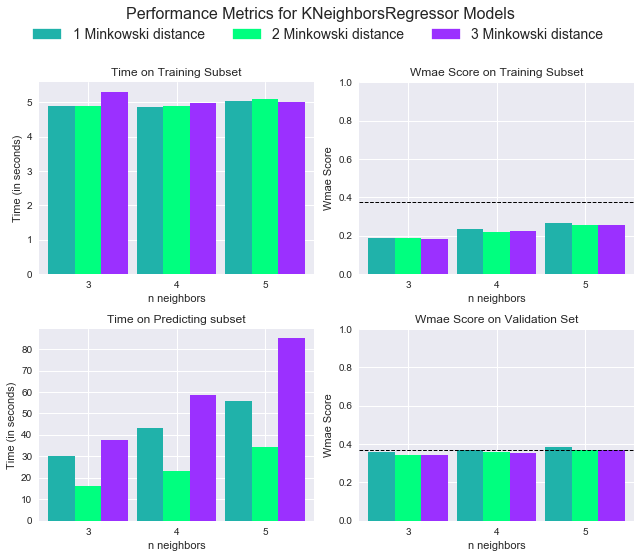

In [13]:
from time import time
from sklearn.neighbors import KNeighborsRegressor

reg_KNNs = []
for neighbors in [2, 3, 4]:
    for p in [1, 2, 3]:
        reg_KNNs.append(KNeighborsRegressor(n_jobs=-1, n_neighbors=neighbors, p=p))

samples_1 = int(0.01*len(y_train))
samples_10 = int(0.1*len(y_train))
samples_100 = len(y_train)

start = time()
results_KNNs = {}
n = 1
for reg in reg_KNNs:
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, samples_100))
    results_KNNs['{}'.format(n)] = train_predict(reg, samples_100, X_train, y_train, X_test, y_test, 0)
    n += 1
end = time()
print('KNN hand_search time:{:.4f}s'.format(end-start))

# print(results_KNNs)
plot_result_KNNs(results_KNNs, wmae_train_last, wmae_test_last)

In [16]:
from time import time
from sklearn.neighbors import KNeighborsRegressor

reg_KNNs = []
for neighbors in [1,2,3]:
    for p in [1, 2, 3]:
        reg_KNNs.append(KNeighborsRegressor(n_jobs=-1, n_neighbors=neighbors, p=p))

samples_1 = int(0.01*len(y_train))
samples_10 = int(0.1*len(y_train))
samples_100 = len(y_train)

start = time()
results_KNNs = {}
n = 1
for reg in reg_KNNs:
    print("{} {} trained on {} samples...".format(reg.__class__.__name__, n, samples_100))
    results_KNNs['{}'.format(n)] = train_predict(reg, samples_100, X_train, y_train, X_test, y_test, 0)
    n += 1
end = time()
print('KNN hand_search time:{:.4f}s'.format(end-start))

# print(results_KNNs)
plot_result_KNNs(results_KNNs, wmae_train_last, wmae_test_last)

KNeighborsRegressor 1 trained on 14400 samples...
{'train time': 5.032062292098999, 'prediction time': 14.69074535369873, 'train_wmae': 0.0, 'test_wmae': 0.3901770766958098}


KNeighborsRegressor 2 trained on 14400 samples...
{'train time': 4.92001748085022, 'prediction time': 5.248217582702637, 'train_wmae': 0.0, 'test_wmae': 0.37584469450514657}


KNeighborsRegressor 3 trained on 14400 samples...
{'train time': 4.941016674041748, 'prediction time': 13.061538696289062, 'train_wmae': 0.0, 'test_wmae': 0.3723677902638649}


KNeighborsRegressor 4 trained on 14400 samples...
{'train time': 4.897020101547241, 'prediction time': 30.46860694885254, 'train_wmae': 0.19118847876119358, 'test_wmae': 0.3600966526115614}


KNeighborsRegressor 5 trained on 14400 samples...
{'train time': 4.929021596908569, 'prediction time': 14.896759510040283, 'train_wmae': 0.1896074391202461, 'test_wmae': 0.3445061294541377}


KNeighborsRegressor 6 trained on 14400 samples...
{'train time': 4.883019685745239, 'pr

NameError: name 'mean_wmae_train' is not defined

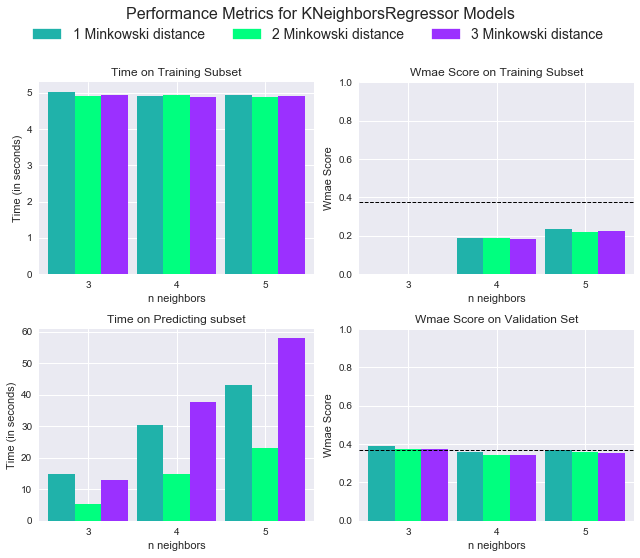

In [17]:
plot_result_KNNs(results_KNNs, wmae_train_last, wmae_test_last)

In [14]:
X_train

,ord_cnt,sale_amt,offer_cnt,offer_amt,rtn_cnt,rtn_amt,user_cnt,charge,consume,cmmt_num,...,cate_301,cate_302,cate_303,cate_304,cate_305,cate_306,cate_307,cate_308,cate_309,cate_310
2465,0.740875,0.774124,0.741776,0.690107,0.323826,0.483819,0.740754,0.000000,0.575610,0.533541,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
8461,0.637024,0.767920,0.230621,0.442901,0.463746,0.694148,0.636681,0.586706,0.860798,0.470540,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
13734,0.732357,0.781753,0.000000,0.000000,0.640784,0.732592,0.731961,0.000000,0.000000,0.539824,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
965,0.518627,0.601197,0.000000,0.000000,0.000000,0.000000,0.518627,0.000000,0.000000,0.254124,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4615,0.529718,0.668798,0.000000,0.000000,0.241970,0.493736,0.529718,0.000000,0.000000,0.338508,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
12167,0.810657,0.803112,0.660342,0.550894,0.411150,0.530312,0.810235,0.493215,0.749582,0.593870,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
15053,0.561192,0.707200,0.557328,0.546970,0.296726,0.542025,0.561192,0.000000,0.000000,0.451544,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
17576,0.516367,0.719493,0.000000,0.000000,0.356394,0.644195,0.515794,0.516575,0.784915,0.350715,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
15280,0.665143,0.714668,0.000000,0.000000,0.323826,0.485444,0.664885,0.000000,0.000000,0.478882,...,0.0,0.0,0.0,0.0,0.54588,0.0,0.0,0.0,0.0,0.0
1082,0.412624,0.609177,0.374355,0.280306,0.000000,0.000000,0.412624,0.000000,0.458393,0.267677,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


#### 6.2.2.3 预测并生成最终结果

In [18]:
reg_KNN_best = KNeighborsRegressor(n_jobs=-1, n_neighbors=2, p=3)
reg_KNN_best.fit(features.drop('shop_id', axis=1), labels)
predictions_KNN_best = reg_KNN_best.predict(features_test)

In [21]:
submission_rm_knn = pd.DataFrame()
submission_rm_knn['shop_id'] = range(1, 3001)
submission_rm_knn['pred_amt'] = predictions_KNN_best
submission_rm_knn = submission_rm_knn.groupby('shop_id')[['pred_amt']].mean()
submission_rm_knn.to_csv('submission/submission_knn_3_full_1m.csv', header=False)

**提交一** 6181111为**0.786665。**     

 **提交二：**KNN 为**0.582138**（val上为0.3965415249333668）（submission_rm_knn.csv）

**提交三**：KNN为**0.645001**（val上为0.30058163997452775）（submission_sklearn_1.csv）

**提交四**：KNN为**0.584953**（submission_knn_3_full.csv）

**提交五**：KNN为**0.602873** (submission/submission_knn_3_full_1m.csv)